In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
train_problems = read_fatahi_dataset("../data/train_data.xlsx")
test_problems = read_fatahi_dataset("../data/fatahi.xlsx")

100%|██████████| 18/18 [00:00<00:00, 15618.01it/s]


In [3]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [4]:
class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]
        graph = dglgraph(problem, gamma, delta)
        graph = dglgraph_fixed(graph)
        return graph.to(device)

In [31]:
info_train = {}
for idx in [int(i.split('_')[-2]) for i in glob('train_solutions/*') if 'op' in i]:
    if idx < 300:
        info_train[idx] = {}
        info_train[idx]['gamma'] = np.load(f'train_solutions/gamma_{idx}_op.npy')
        info_train[idx]['delta'] = np.load(f'train_solutions/delta_{idx}_op.npy')
        info_train[idx]['problem'] = train_problems[idx]

info_test = {}
for idx in [int(i.split('_')[-2]) for i in glob('fatahi_solutions/*') if 'op' in i]:
    info_test[idx] = {}
    info_test[idx]['gamma'] = np.load(f'fatahi_solutions/gamma_{idx}_op.npy')
    info_test[idx]['delta'] = np.load(f'fatahi_solutions/delta_{idx}_op.npy')
    info_test[idx]['problem'] = train_problems[idx]

In [32]:
train_idx, test_idx = train_test_split(list(info_train.keys()),
                                       random_state=42,train_size=0.8)

In [33]:
train_dataset = GraphDataset([info_train[i]['problem'] for i in train_idx],
                             [info_train[i]['gamma'] for i in train_idx],
                             [info_train[i]['delta'] for i in train_idx])

test_dataset = GraphDataset([info_train[i]['problem'] for i in test_idx],
                             [info_train[i]['gamma'] for i in test_idx],
                             [info_train[i]['delta'] for i in test_idx])

# train_dataset = GraphDataset([info_train[i]['problem'] for i in sorted(info_train.keys())],
#                              [info_train[i]['gamma'] for i in sorted(info_train.keys())],
#                              [info_train[i]['delta'] for i in sorted(info_train.keys())])

# test_dataset = GraphDataset([info_test[i]['problem'] for i in sorted(info_test.keys())],
#                              [info_test[i]['gamma'] for i in sorted(info_test.keys())],
#                              [info_test[i]['delta'] for i in sorted(info_test.keys())])

In [34]:
train_batch = 80
test_batch = 20
train_loader = GraphDataLoader(train_dataset, batch_size=train_batch, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=test_batch, shuffle=True)

In [35]:
from joblib import Parallel, delayed

def validate_objective(model, dataset):
    test_objvalue = []
    for i in range(len(dataset.problems)):
        delta = dataset.deltas[i]
        pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
        test_objvalue.append(
            objvalue(dataset.problems[i], pred_gamma, pred_delta)
        )
    # def process_objective(model, dataset, i):
    #     pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
    #     return objvalue(dataset.problems[i], pred_gamma, pred_delta)
    
    # test_objvalue = Parallel(n_jobs=-1)(
    #     delayed(process_objective)(model, dataset, i) for i in range(len(dataset.problems))
    # )
    return np.mean(test_objvalue)

In [36]:
i=0
gamma = info_train[i]['gamma']
delta = info_train[i]['delta']
problem = train_problems[i]

print(problem['operations'])
print(gamma.sum())
print(delta.sum())

[[1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0.]]
15.0
3.0


In [37]:
idx=0
gamma = info_train[idx]['gamma']
delta = info_train[idx]['delta']
for op_num in range(train_problems[idx]['operations'].shape[1]):
    city_list = []
    for i, sub_op in enumerate(np.nonzero(train_problems[idx]['operations'][:,op_num])[0]):
        c = np.nonzero(gamma[sub_op, op_num,:])
        city_list.append(c)
        if i != 0:
            print(city_list[i-1][0], c[0])
            print(delta[:,city_list[i-1],c,sub_op,op_num].reshape(-1))
    print('\n')

[1] [1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1] [4]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]




In [38]:
def print_all(loss_list_train, loss_list_test,
              objvalue_train, objvalue_test):
    plt.plot(loss_list_train, label='train loss')
    plt.plot(loss_list_test, label='test loss')
    plt.legend()
    plt.show()

    plt.plot(objvalue_train, label='train objective')
    plt.plot(objvalue_test, label='test objective')
    plt.legend()
    plt.show()

In [39]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss)

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [40]:
from torch.optim.lr_scheduler import ExponentialLR
def run_experiment(out_dim=15, lr=1e-4, layers=1, epochs=800):
    model = GNN(s_shape_init=1, o_shape_init=20, os_shape_init=2,
            ss_shape_init=10, out_dim=out_dim, n_layers=layers).to(device)
    optim = Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optim, gamma=0.98)

    loss_list_train = []
    objvalue_train = []
    loss_list_test = []
    objvalue_test = []
    for epoch in trange(epochs):
        ep_loss_train = []
        ep_loss_test = []
        loss=0
        for graph in train_loader:
            optim.zero_grad()
            # take initial info
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            # Forward pass
            logits, delta_logits = model(graph)
            # loss calculation
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            service_loss = F.cross_entropy(delta_logits[mask.bool()],
                                        delta_target[mask.bool()])
            loss = operation_loss + service_loss*0.5
            loss.backward()
            optim.step()
            ep_loss_train.append(loss.item())

        for graph in test_loader:
            with torch.no_grad():
                # take initial info
                gamma_target = graph.edata["target"][os_type]
                delta_target = graph.edata["delta_target"][ss_type]
                mask = graph.edata["mask"][ss_type]
                # Forward pass
                logits, delta_logits = model(graph)
                # loss calculation
                operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                service_loss = F.cross_entropy(delta_logits[mask.bool()],
                                            delta_target[mask.bool()])
                loss = operation_loss + service_loss*0.5
    
                ep_loss_test.append(loss.item())
        loss_list_train.append(np.mean(ep_loss_train))
        loss_list_test.append(np.mean(ep_loss_test))

        if (epoch + 1) % 30 == 0:
            objvalue_train.append(validate_objective(model, train_dataset))
            objvalue_test.append(validate_objective(model, test_dataset))
            scheduler.step()

    print_all(loss_list_train, loss_list_test,
                objvalue_train, objvalue_test)

32 0.01


100%|██████████| 1000/1000 [1:12:54<00:00,  4.37s/it]


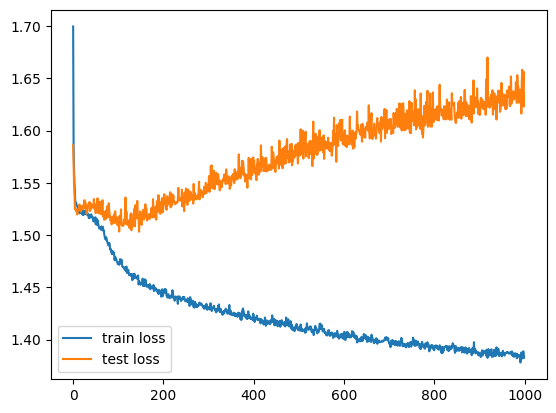

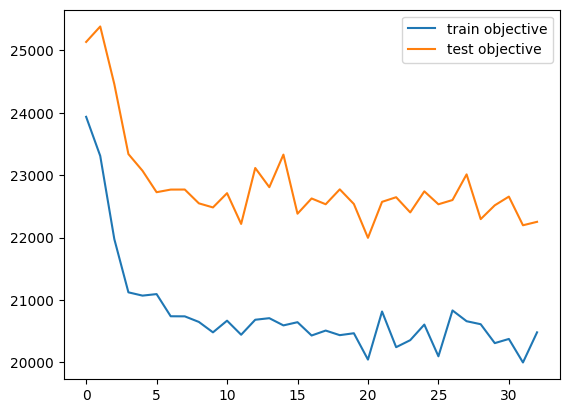

In [41]:
for dim in [32]:
    for lr in [1e-2]:
        print(dim, lr)
        run_experiment(out_dim=dim, lr=lr, epochs=1000)